In [1]:
# load both datasets
# use the intensity parts to figure out which ones come from the same image
# use the per-image stddev of pair-wise angular distance as a measure of spread for HPA
# use pseudotime prediction error for FUCCI
# get a joint PCA
# plot the PCs for each dataset separately, colored by the spread
# also plot in 3D with the fucci-dataset grayed out

from pathlib import Path
import torch
import numpy as np
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from HPA_CC.data.dataset import RefCLSDM
from HPA_CC.models.train import find_checkpoint_file, CombinedModelLit
from HPA_CC.models.utils import combined_inference
from config import HPA_DS_PATH, FUCCI_DS_PATH

In [2]:
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
log_dirs_home = Path('/data/ishang/pseudotime_pred/')
data_name = "minimal"
device = "cuda:7"

In [3]:
model_name = "HPA DINO Multi-model"
model_hash = "s41dnlu2" # soft without dropout
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
scope = True
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=False)
combined_model = CombinedModelLit.load_from_checkpoint(checkpoint_file)
combined_model.to(device)
combined_model.eval()

/home/ishang/HPA_CC/src/HPA_CC/models/train.py:471: UserWarning: Soft and focal loss are both enabled, soft loss will be coerced into regular cross entropy loss
  warn("Soft and focal loss are both enabled, soft loss will be coerced into regular cross entropy loss")


CombinedModelLit(
  (model): OptimizedModule(
    (_orig_mod): CombinedModel(
      (model): Sequential(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=4096, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=4096, out_features=4096, bias=True)
        (5): GELU(approximate='none')
        (6): Linear(in_features=4096, out_features=4096, bias=True)
        (7): GELU(approximate='none')
        (8): Linear(in_features=4096, out_features=32, bias=True)
      )
      (pseudotime): Linear(in_features=32, out_features=1, bias=True)
      (angle): Linear(in_features=32, out_features=1, bias=True)
      (phase): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
      )
      (phase_loss_fn): FocalLoss(alpha=tensor([0.1000, 0.2500, 0.4000, 0.2500]), gamma=2.0, ignore_index=-100, reduction='mean')
    )
  )
)

In [4]:
HPA_dm = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=int_stats)
FUCCI_dm = RefCLSDM(FUCCI_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=int_stats)
h_pseudo_preds, h_angle_preds, h_phase_preds = combined_inference(combined_model, HPA_dm.inference_dataloader(), device)
f_pseudo_preds, f_angle_preds, f_phase_preds = combined_inference(combined_model, FUCCI_dm.inference_dataloader(), device)

Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/all_HPA-CC-dataset/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([1870, 1536])
X shape: torch.Size([1870, 2048])
Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt


Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([31737, 1536])
X shape: torch.Size([31737, 2048])


/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


In [5]:
h_X = HPA_dm.dataset.X
h_embed, h_int = h_X[:, :1536], h_X[:, 1536:]
f_X = FUCCI_dm.dataset.X
f_embed, f_int = f_X[:, :1536], f_X[:, 1536:]
print(h_embed.shape, h_int.shape, f_embed.shape, f_int.shape)

torch.Size([1870, 1536]) torch.Size([1870, 512]) torch.Size([31737, 1536]) torch.Size([31737, 512])


In [6]:
def get_image_ids(int_array):
    img_ids = np.zeros((len(int_array)))
    int_profiles = {}
    curr_int = int_array[0]
    curr_id = 0
    for i in range(len(int_array)):
        if not np.array_equal(int_array[i], curr_int):
            curr_int = int_array[i]
            curr_id += 1
        img_ids[i] = curr_id
    print(curr_id + 1)
    return img_ids

h_img_ids = get_image_ids(h_int)
f_img_ids = get_image_ids(f_int)


134


2222


In [7]:
def angular_distance(x, y):
    return np.minimum(np.abs(x - y), 2 * np.pi - np.abs(x - y))

def calc_im_spread(preds, sc_ints, img_ids):
    # spread = np.zeros_like(img_ids)
    spread = []
    img_ints = []
    for img in np.unique(img_ids):
        img_preds = preds[img_ids == img]
        img_int = sc_ints[np.argmax((img_ids == img))]
        img_ints.append(img_int)
        # dists = angular_distance(img_preds[:, None], img_preds[None, :]) # get all pairwise distances
        # dists = dists[np.triu_indices(dists.shape[0], k=1)]  # get upper triangle values to avoid duplicate pairs and self-pairs
        # spread[img_ids == img] = np.std(dists)
        # modes = mode(img_preds).mode
        # if not isinstance(modes, np.ndarray):
        #     modes = np.array([modes])
        # print(mode(img_preds))
        modes = np.array([np.median(img_preds)])
        # spread[img_ids == img] = min([np.sum((angular_distance(m, img_preds)) < 0.1) / len(img_preds) for m in modes])
        spread.append(min([np.sum((angular_distance(m, img_preds)) < 0.1) / len(img_preds) for m in modes]))
    spread, img_ints = np.stack(spread), np.array(img_ints)
    return img_ints, spread

# h_angle_spread = calc_pairwise_angle_stddev(h_pseudo_preds, h_img_ids)
# f_angle_spread = calc_pairwise_angle_stddev(f_pseudo_preds, f_img_ids)
h_img_ints, h_angle_spread = calc_im_spread(h_pseudo_preds, h_int, h_img_ids)
print(h_img_ints.shape, h_angle_spread.shape)
f_img_ints, f_angle_spread = calc_im_spread(f_pseudo_preds, f_int, f_img_ids)
print(f_img_ints.shape, f_angle_spread.shape)

(134, 512) (134,)
(2222, 512) (2222,)


(134, 3) (2222, 3)


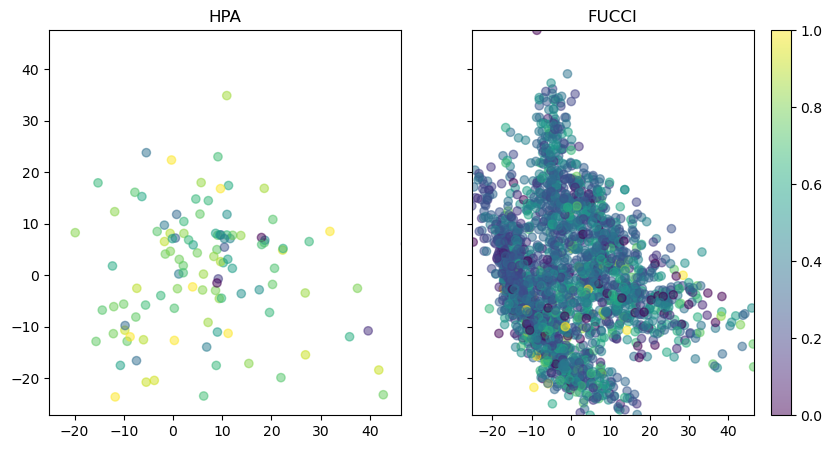

In [8]:
scale, pca = StandardScaler(), PCA(n_components=3)
# h_samples = np.random.choice(len(h_img_ints), len(h_img_ints))
# f_samples = np.random.choice(len(f_img_ints), len(f_img_ints))
# X_input = np.concatenate([h_img_ints[h_samples], f_img_ints[f_samples]], axis=0)
# scale.fit(X_input)
# pca.fit(scale.transform(X_input))
# X_pca = pca.transform(scale.transform(np.concatenate([h_img_ints, f_img_ints], axis=0)))
X_pca = pca.fit_transform(scale.fit_transform(np.concatenate([h_img_ints, f_img_ints], axis=0)))
h_pca = X_pca[:len(h_img_ints)]
f_pca = X_pca[len(h_img_ints):]
print(h_pca.shape, f_pca.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
x_min, y_min = np.min(f_pca[:, 0]), np.min(f_pca[:, 1])
x_max, y_max = np.max(f_pca[:, 0]), np.max(f_pca[:, 1])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
ax[0].scatter(h_pca[:, 0], h_pca[:, 1], c=h_angle_spread, cmap="viridis", alpha=0.5)
ax[0].set_title("HPA")
sc = ax[1].scatter(f_pca[:, 0], f_pca[:, 1], c=f_angle_spread, cmap="viridis", alpha=0.5)
ax[1].set_title("FUCCI")
plt.colorbar(sc)
plt.show()

In [9]:
# plt.figure(figsize=(10, 8))
# plt.scatter(f_pca[:, 0], f_pca[:, 1], c=range(len(f_pca)), cmap='viridis')
# plt.colorbar(label='Index')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.title('PCA plot colored by index')
# plt.show()


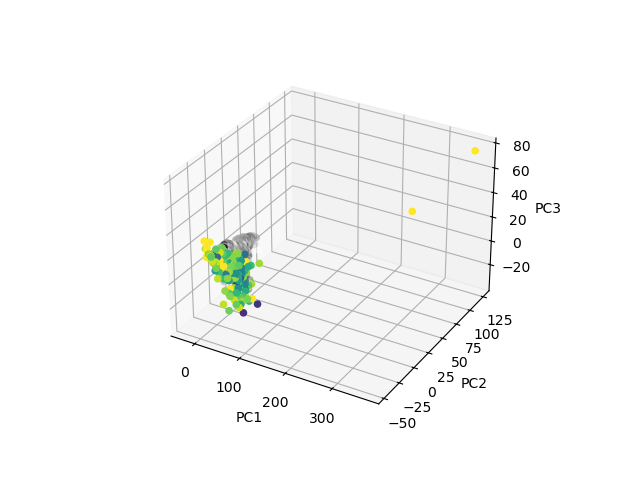

In [10]:
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], c=h_angle_spread, cmap="viridis", alpha=1.0)
ax.scatter(f_pca[:, 0], f_pca[:, 1], f_pca[:, 2], c=f_angle_spread, cmap="binary", alpha=0.5)
# ax.scatter(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], c=h_angle_spread, cmap="binary", alpha=1.0)
# ax.scatter(f_pca[:, 0], f_pca[:, 1], f_pca[:, 2], c=range(len(f_pca)), cmap="viridis", alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()